In [ ]:
# ----------------------------
# Prophet Forecasting - Superstore.csv (Daily Sales)
# ----------------------------



import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
# ----------------------------
# 1) Load + prepare daily series for Prophet (ds, y)
# ----------------------------
df_raw = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")

df_raw["Order Date"] = pd.to_datetime(df_raw["Order Date"], errors="coerce")
df_raw = df_raw.dropna(subset=["Order Date"])

daily = (
    df_raw.groupby("Order Date")["Sales"]
          .sum()
          .asfreq("D")
          .fillna(0.0)
          .reset_index()
          .rename(columns={"Order Date": "ds", "Sales": "y"})
)

daily.head()

,ds,y
0,2014-01-03,32.896
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,8814.200
4,2014-01-07,174.316


In [ ]:
# ----------------------------
# 2) Train/Test split (last 90 days)
# ----------------------------
test_days = 90
train_df = daily.iloc[:-test_days].copy()
test_df  = daily.iloc[-test_days:].copy()


In [ ]:
# ----------------------------
# 3) Build + fit Prophet model
# ----------------------------
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)

m.fit(train_df)


In [ ]:
# ----------------------------
# 4) Forecast test horizon + evaluate
# ----------------------------
future = m.make_future_dataframe(periods=test_days, freq="D")
fc = m.predict(future)

fc_test = fc.tail(test_days).set_index("ds")["yhat"]
y_test  = test_df.set_index("ds")["y"]

rmse = np.sqrt(mean_squared_error(y_test, fc_test))
mae  = mean_absolute_error(y_test, fc_test)
mape = (np.mean(np.abs((y_test - fc_test) / np.maximum(np.abs(y_test), 1e-9))) * 100)

print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"MAPE: {mape:,.2f}%")


RMSE: 3,977.81
MAE : 3,041.13
MAPE: 6,882,465,059,929.26%


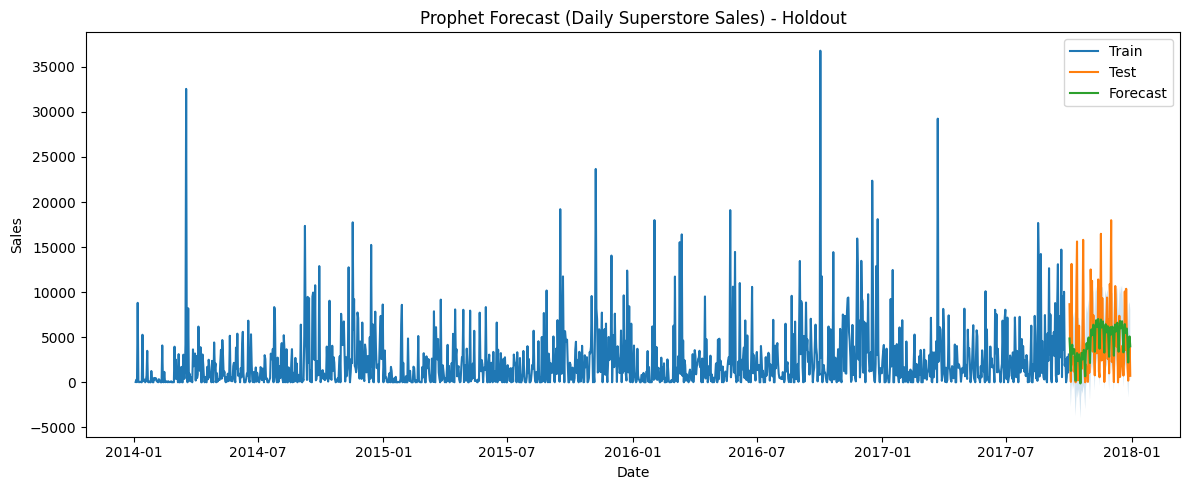

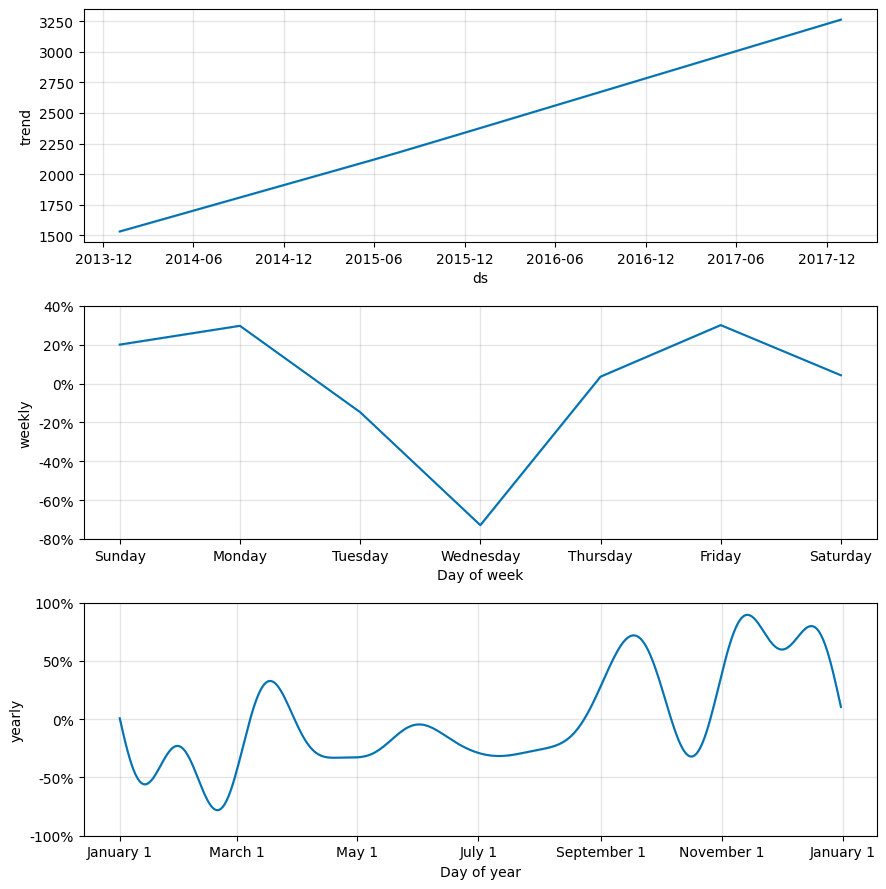

In [ ]:
# ----------------------------
# 5) Plot Train/Test + Forecast
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(train_df["ds"], train_df["y"], label="Train")
plt.plot(test_df["ds"], test_df["y"], label="Test")
plt.plot(fc.tail(test_days)["ds"], fc.tail(test_days)["yhat"], label="Forecast")
plt.fill_between(
    fc.tail(test_days)["ds"],
    fc.tail(test_days)["yhat_lower"],
    fc.tail(test_days)["yhat_upper"],
    alpha=0.2
)
plt.title("Prophet Forecast (Daily Superstore Sales) - Holdout")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

# Prophet components
m.plot_components(fc)
plt.show()

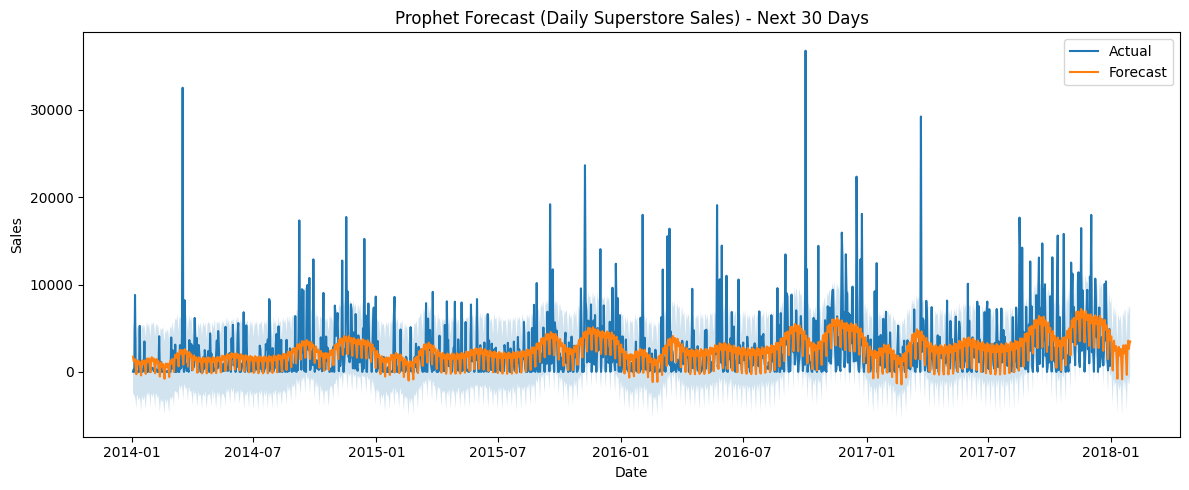

Saved: superstore_prophet_forecast_next_30_days.csv


In [ ]:
# ----------------------------
# 6) Refit on FULL data + forecast next 30 days
# ----------------------------
m_final = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)

m_final.fit(daily)

horizon_days = 30
future_30 = m_final.make_future_dataframe(periods=horizon_days, freq="D")
fc_30 = m_final.predict(future_30)

# Plot full + future
plt.figure(figsize=(12,5))
plt.plot(daily["ds"], daily["y"], label="Actual")
plt.plot(fc_30["ds"], fc_30["yhat"], label="Forecast")
plt.fill_between(fc_30["ds"], fc_30["yhat_lower"], fc_30["yhat_upper"], alpha=0.2)
plt.title("Prophet Forecast (Daily Superstore Sales) - Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

# Save forecast CSV
out = fc_30[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(horizon_days).copy()
out.to_csv("superstore_prophet_forecast_next_30_days.csv", index=False)
print("Saved: superstore_prophet_forecast_next_30_days.csv")



In [ ]:
# ----------------------------
# 7) Serialize model for Streamlit
# ----------------------------
os.makedirs("models", exist_ok=True)

with open("models/prophet_superstore.pkl", "wb") as f:
    pickle.dump(m_final, f)

print("Saved: models/prophet_superstore.pkl")

Saved: models/prophet_superstore.pkl


In [ ]:
# ----------------------------
# Prophet model serialization (Superstore)
# Saves: model .pkl + config .json
# ----------------------------
import os
import pickle
import json

# m_final should be your fitted Prophet model (after m_final.fit(...))
os.makedirs("models", exist_ok=True)

# 1) Save the fitted Prophet model
with open("models/prophet_superstore.pkl", "wb") as f:
    pickle.dump(m_final, f)

# 2) Save simple config (helps Streamlit know how to forecast)
config = {
    "model_name": "Prophet (Superstore)",
    "freq": "D",
    "default_horizon": 30,
    "columns": {"date": "ds", "target": "y"}
}

with open("models/prophet_superstore_config.json", "w") as f:
    json.dump(config, f, indent=2)

print("Saved: models/prophet_superstore.pkl and models/prophet_superstore_config.json")


Saved: models/prophet_superstore.pkl and models/prophet_superstore_config.json


In [ ]:
# ----------------------------
# (Optional) Load it back (sanity check)
# ----------------------------
import pickle
import pandas as pd

with open("models/prophet_superstore.pkl", "rb") as f:
    m_loaded = pickle.load(f)

horizon = 30
future = m_loaded.make_future_dataframe(periods=horizon, freq="D")
forecast = m_loaded.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
1483,2018-01-25,2691.509319,-1316.318926,6629.495605
1484,2018-01-26,3579.777950,-517.019962,7617.742335
1485,2018-01-27,2642.739449,-1661.455184,6510.101950
1486,2018-01-28,3171.136478,-877.366248,7048.351008
1487,2018-01-29,3494.232282,-493.596779,7738.619559
